# Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns",None)
df = pd.read_csv(r"EasyVisa.csv")

print(df.shape)

(25480, 12)


## Data Cleaning

In [2]:
features_wna = [feature for feature in df.columns if df[feature].isnull().sum()>=1]
for feature in features_wna:
    print(feature, np.round(df[feature].isnull().mean()*100,5), '% missing values')

In [3]:
features_wna

[]

### There are no null values in the dataset

#### lets check for duplicates

In [4]:
df.duplicated().sum()

0

### There are no duplicate rows

## Feature Extraction

In [5]:
df.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [6]:
from datetime import date
todays_date = date.today()

current_year = todays_date.year

In [7]:
current_year

2025

Lets find the age of the company

In [9]:
df['company_age'] = current_year - df['yr_of_estab']

In [10]:
df.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,company_age
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied,18
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified,23
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied,17
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied,128
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified,20


In [11]:
df.drop('yr_of_estab',inplace=True, axis=1)

Types of features
Numerical features and categorical features

In [12]:
numerical_features = [feature for feature in df.columns if df[feature].dtype!='O']
print(numerical_features)

['no_of_employees', 'prevailing_wage', 'company_age']


In [13]:
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print(categorical_features)

['case_id', 'continent', 'education_of_employee', 'has_job_experience', 'requires_job_training', 'region_of_employment', 'unit_of_wage', 'full_time_position', 'case_status']


### Split the dataframe into x and y

In [14]:
X = df.drop('case_status',axis=1)
y = df['case_status']

In [15]:
y.head()

0       Denied
1    Certified
2       Denied
3       Denied
4    Certified
Name: case_status, dtype: object

In [16]:
y = np.where(y=='Denied',1,0)

In [17]:
y

array([1, 0, 1, ..., 0, 0, 0])

## Feature Transformation

In [18]:
X.columns

Index(['case_id', 'continent', 'education_of_employee', 'has_job_experience',
       'requires_job_training', 'no_of_employees', 'region_of_employment',
       'prevailing_wage', 'unit_of_wage', 'full_time_position', 'company_age'],
      dtype='object')

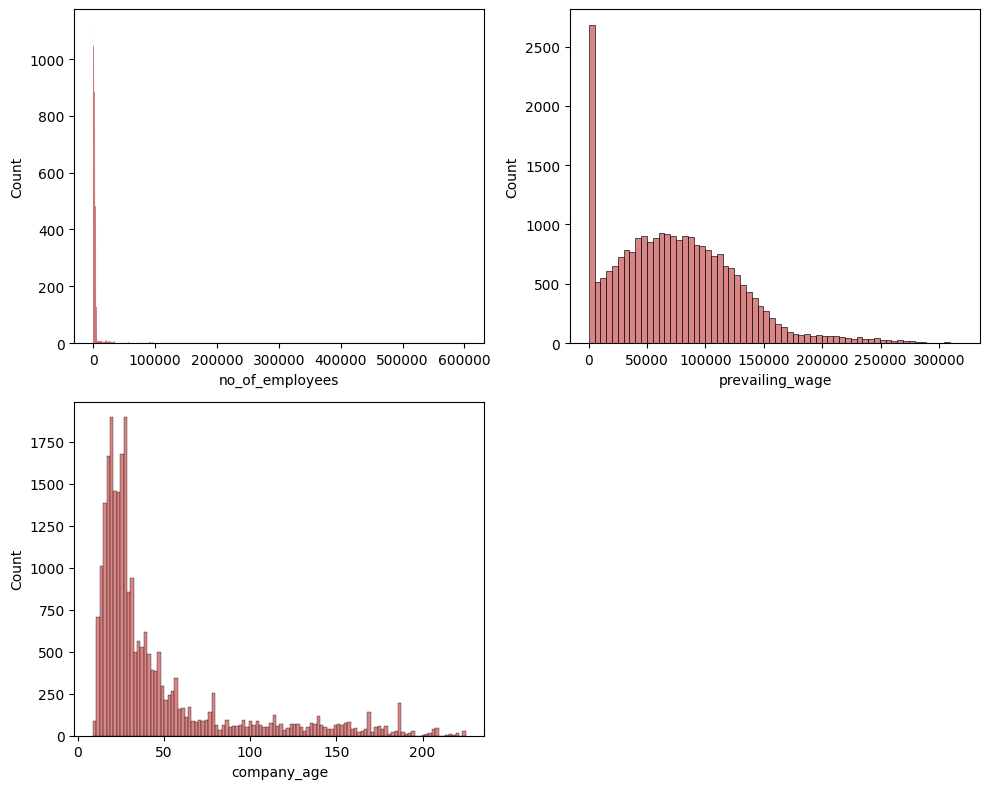

In [19]:
# lets check the distribution of data before scaling

plt.figure(figsize=(10,8))
for i,j in enumerate(['no_of_employees','prevailing_wage','company_age']):
    plt.subplot(2,2,i+1)
    sns.histplot(x=X[j],color="indianred")
    plt.xlabel(j)
    plt.tight_layout()

#### Since skewness exists in the above we will apply power transform to make the data more gaussian

In [20]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer('yeo-johnson')
transform_feature = ['company_age','no_of_employees']
X_copy = pt.fit_transform(X[transform_feature])

In [21]:
X_copy = pd.DataFrame(X_copy, columns=transform_feature)

In [22]:
X_copy.head()

,company_age,no_of_employees
0,-0.955551,1.517300
1,-0.467001,0.030912
2,-1.078363,2.885076
3,1.630914,-1.343550
4,-0.738126,-0.432287


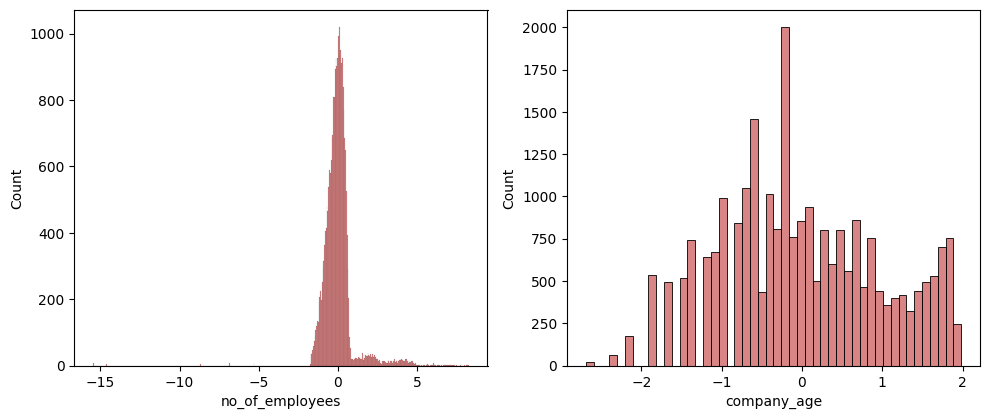

In [23]:

plt.figure(figsize=(10,8))
for i,j in enumerate(['no_of_employees','company_age']):
    plt.subplot(2,2,i+1)
    sns.histplot(x=X_copy[j],color="indianred")
    plt.xlabel(j)
    plt.tight_layout()

In [24]:
X_copy.skew(axis=0,skipna=True)

company_age        0.112260
no_of_employees    0.399339
dtype: float64

## Feature Encoding and Scaling Techniques

In [26]:
num_features = list(X.select_dtypes(exclude="object").columns)

In [27]:
num_features

['no_of_employees', 'prevailing_wage', 'company_age']

In [28]:
# Create Column Transformer with 3 types of transformers
or_columns = ['has_job_experience','requires_job_training','full_time_position','education_of_employee']
oh_columns = ['continent','unit_of_wage','region_of_employment']
transform_columns= ['no_of_employees','company_age']

from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()
ordinal_encoder = OrdinalEncoder()

transform_pipe = Pipeline(steps=[
    ('transformer', PowerTransformer(method='yeo-johnson'))
])

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, oh_columns),
        ("Ordinal_Encoder", ordinal_encoder, or_columns),
        ("Transformer", transform_pipe, transform_columns),
        ("StandardScaler", numeric_transformer, num_features)
    ]
)

In [29]:


X = preprocessor.fit_transform(X)



## Classification

In [30]:


from imblearn.combine import SMOTETomek, SMOTEENN

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTEENN(random_state=42,sampling_strategy='minority' )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X, y)



In [31]:


from sklearn.model_selection import  train_test_split
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)
X_train.shape, X_test.shape



((13629, 24), (3408, 24))

In [32]:


from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve 
from xgboost import XGBClassifier
from catboost import CatBoostClassifier



In [33]:


def evaluate_clf(true, predicted):
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc



In [34]:


models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
     "Support Vector Classifier": SVC(),
    "AdaBoost Classifier": AdaBoostClassifier()

}



In [35]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    models_list = []
    accuracy_list = []
    auc= []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        accuracy_list.append(model_test_accuracy)
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        auc.append(model_test_rocauc_score)
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list, accuracy_list)), columns=['Model Name', 'Accuracy']).sort_values(by=['Accuracy'], ascending=False)
        
    return report

In [36]:


base_model_report =evaluate_models(X=X_res, y=y_res, models=models)



Random Forest
Model performance for Training set
- Accuracy: 0.9999
- F1 score: 0.9999
- Precision: 1.0000
- Recall: 0.9999
- Roc Auc Score: 0.9999
----------------------------------
Model performance for Test set
- Accuracy: 0.9531
- F1 score: 0.9567
- Precision: 0.9526
- Recall: 0.9609
- Roc Auc Score: 0.9524


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9252
- F1 score: 0.9313
- Precision: 0.9236
- Recall: 0.9391
- Roc Auc Score: 0.9240


Gradient Boosting
Model performance for Training set
- Accuracy: 0.8897
- F1 score: 0.8965
- Precision: 0.9068
- Recall: 0.8865
- Roc Auc Score: 0.8900
----------------------------------
Model performance for Test set
- Accuracy: 0.8791
- F1 score: 0.8875
- Precision: 0.8919
- Recall: 0.8832
- Roc Auc Score: 0.8788


Logistic Regression
Model performance for Training 

In [37]:
base_model_report

,Model Name,Accuracy
0,Random Forest,0.953052
4,K-Neighbors Classifier,0.941608
5,XGBClassifier,0.935153
6,CatBoosting Classifier,0.928110
1,Decision Tree,0.925176
2,Gradient Boosting,0.879108
7,Support Vector Classifier,0.857101
8,AdaBoost Classifier,0.849178
3,Logistic Regression,0.725646




Here we can use Random Forest for Hyper Parameter Tuning

Define the parameter distribution for Random forest


In [38]:


#Initialize few parameter for Hyperparamter tuning
xgboost_params = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

rf_params = {
    "max_depth": [10, 12, None, 15, 20],
    "max_features": ['sqrt', 'log2', None],
    "n_estimators": [10, 50, 100, 200]
}

knn_params = {
    "algorithm": ['auto', 'ball_tree', 'kd_tree','brute'],
    "weights": ['uniform', 'distance'],
    "n_neighbors": [3, 4, 5, 7, 9],
}



In [39]:


# Models list for Hyperparameter tuning
randomcv_models = [
    ('XGBoost', XGBClassifier(), xgboost_params),
    ("RF", RandomForestClassifier(), rf_params),
    ("KNN", KNeighborsClassifier(), knn_params)
]



Create a function for model training and report which can be used in hyperparameter tuning loop

In [40]:
from sklearn.model_selection import RandomizedSearchCV

model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2, 
                                   n_jobs=-1)
    random.fit(X_res, y_res)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ....................max_depth=3, min_child_weight=1; total time=   0.5s
[CV] END ....................max_depth=3, min_child_weight=3; total time=   0.6s
[CV] END ....................max_depth=3, min_child_weight=1; total time=   0.7s
[CV] END ....................max_depth=3, min_child_weight=3; total time=   0.6s
[CV] END ....................max_depth=3, min_child_weight=5; total time=   0.6s
[CV] END ....................max_depth=3, min_child_weight=5; total time=   0.3s
[CV] END ....................max_depth=3, min_child_weight=3; total time=   0.7s
[CV] END ....................max_depth=3, min_child_weight=1; total time=   0.8s
[CV] END ....................max_depth=3, min_child_weight=5; total time=   0.8s
[CV] END ....................max_depth=5, min_child_weight=1; total time=   0.4s
[CV] END ....................max_depth=5, min_child_weight=3; total time=   0.4s
[CV] END ....................max_depth=5, min_ch

In [42]:


model_param



{'XGBoost': {'min_child_weight': 1, 'max_depth': 9},
 'RF': {'n_estimators': 200, 'max_features': 'log2', 'max_depth': None},
 'KNN': {'weights': 'distance', 'n_neighbors': 4, 'algorithm': 'auto'}}

## Retraining the model with imporved parameters

In [43]:


from sklearn.metrics import roc_auc_score,roc_curve
best_models = {
    "Random Forest Classifier": RandomForestClassifier(**model_param['RF']),
    "KNeighborsClassifier": KNeighborsClassifier(**model_param['KNN']),
    "XGBClassifier": XGBClassifier(**model_param['XGBoost'],n_jobs=-1),
}
tuned_report =evaluate_models(X=X_res, y=y_res, models=best_models)



Random Forest Classifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9513
- F1 score: 0.9552
- Precision: 0.9490
- Recall: 0.9614
- Roc Auc Score: 0.9504


KNeighborsClassifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9683
- F1 score: 0.9711
- Precision: 0.9577
- Recall: 0.9848
- Roc Auc Score: 0.9669


XGBClassifier
Model performance for Training set
- Accuracy: 0.9996
- F1 score: 0.9996
- Precision: 0.9992
- Recall: 1.0000
- Roc Auc Score: 0.9995
----------------------------------
Model performance for Test set
- Accuracy: 0.9448
- F1 score: 0.9491
- Precision: 0.9455
- Recall: 0.9527
- Roc Auc Score: 0.9442




In [44]:
tuned_report


,Model Name,Accuracy
1,KNeighborsClassifier,0.968310
0,Random Forest Classifier,0.951291
2,XGBClassifier,0.944836


In [45]:
best_model = KNeighborsClassifier(**model_param['KNN'])
best_model = best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
score = accuracy_score(y_test,y_pred)
cr = classification_report(y_test,y_pred)

print("FINAL MODEL 'KNN'")
print ("Accuracy Score value: {:.4f}".format(score))
print (cr)

FINAL MODEL 'KNN'
Accuracy Score value: 0.9683
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1568
           1       0.96      0.98      0.97      1840

    accuracy                           0.97      3408
   macro avg       0.97      0.97      0.97      3408
weighted avg       0.97      0.97      0.97      3408



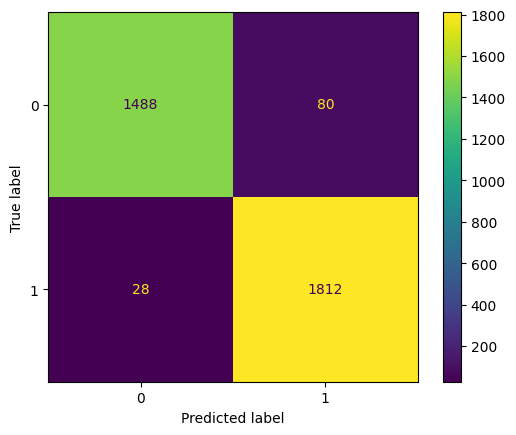

In [46]:


from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)



## KNN is the best model